In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import date, timedelta
from math import sqrt
import warnings

warnings.filterwarnings("ignore")

# Optional: Uncomment to install if running in Jupyter
!pip install pmdarima --quiet
try:
    import pmdarima as pm
except ImportError:
    print("pmdarima not installed. Please run: pip install pmdarima")


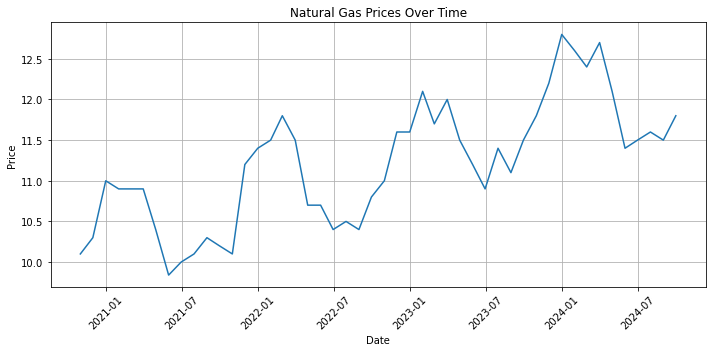

In [6]:

# =====================================
# LOAD & PLOT HISTORICAL DATA
# =====================================

df = pd.read_csv('Nat_Gas.csv', parse_dates=['Dates'])
prices = df['Prices'].values
dates = df['Dates'].values

# Plot raw price data
plt.figure(figsize=(10, 5))
plt.plot(dates, prices, '-')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Natural Gas Prices Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


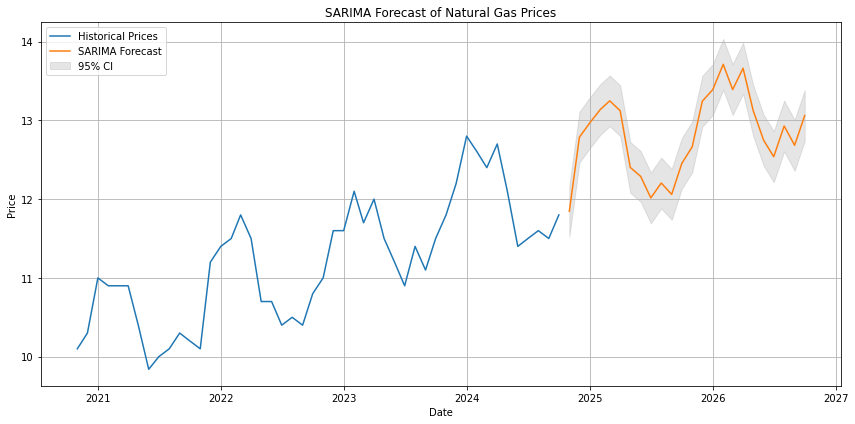

In [7]:

# =====================================
# METHOD 1: SARIMA FORECASTING
# =====================================

def sarima_forecast(data, periods=24):
    model = pm.auto_arima(data, start_p=1, start_q=1, max_p=3, max_q=3, m=12,
                          seasonal=True, d=None, D=1, trace=False,
                          error_action='ignore', suppress_warnings=True,
                          stepwise=True)
    forecast, confint = model.predict(n_periods=periods, return_conf_int=True)
    index_of_fc = pd.date_range(df['Dates'].iloc[-1] + pd.DateOffset(months=1), periods=periods, freq='M')

    # Plot forecast
    plt.figure(figsize=(12, 6))
    plt.plot(df['Dates'], data, label='Historical Prices')
    plt.plot(index_of_fc, forecast, label='SARIMA Forecast')
    plt.fill_between(index_of_fc, confint[:, 0], confint[:, 1], color='gray', alpha=0.2, label='95% CI')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('SARIMA Forecast of Natural Gas Prices')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

sarima_forecast(df['Prices'])


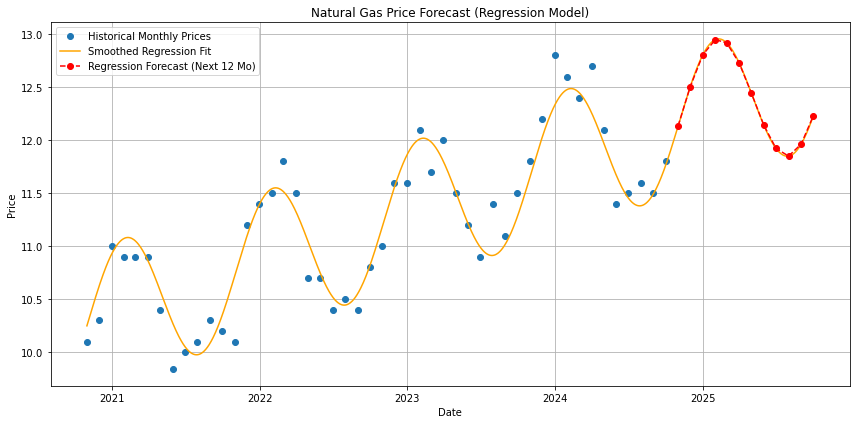

In [11]:

# =====================================
# METHOD 2: LINEAR + SINUSOIDAL MODELING
# =====================================

# Step 1: Define time range and convert to days
start_date = date(2020, 10, 31)
end_date = date(2024, 9, 30)
months = []
year = start_date.year
month = start_date.month + 1
while True:
    current = date(year, month, 1) + timedelta(days=-1)
    months.append(current)
    if current.month == end_date.month and current.year == end_date.year:
        break
    month = ((month + 1) % 12) or 12
    if month == 1:
        year += 1

days_from_start = [(day - start_date).days for day in months]
time = np.array(days_from_start)

# Step 2: Linear regression
def simple_regression(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    slope = np.sum((x - xbar) * (y - ybar)) / np.sum((x - xbar)**2)
    intercept = ybar - slope * xbar
    return slope, intercept

slope, intercept = simple_regression(time, prices)

# Step 3: Detrend and fit sinusoidal component
residual = prices - (slope * time + intercept)
sin_time = np.sin(time * 2 * np.pi / 365)
cos_time = np.cos(time * 2 * np.pi / 365)

def bilinear_regression(y, x1, x2):
    slope1 = np.sum(y * x1) / np.sum(x1 ** 2)
    slope2 = np.sum(y * x2) / np.sum(x2 ** 2)
    return slope1, slope2

slope1, slope2 = bilinear_regression(residual, sin_time, cos_time)

# Step 4: Recover amplitude and phase
amplitude = np.sqrt(slope1 ** 2 + slope2 ** 2)
shift = np.arctan2(slope2, slope1)

# Step 5: Forecasting function
def interpolate(target_date):
    days = (target_date - pd.Timestamp(start_date)).days
    return amplitude * np.sin(days * 2 * np.pi / 365 + shift) + days * slope + intercept


# Step 6: Predict next 12 months
future_dates = pd.date_range(start=pd.Timestamp(dates[-1]) + pd.DateOffset(months=1), periods=12, freq='M')
predicted_prices = [interpolate(date) for date in future_dates]
# Step 7: Plot full regression: historical + forecast
# Generate continuous date range from start to future end
full_dates = pd.date_range(start=pd.Timestamp(start_date), end=future_dates[-1], freq='D')
full_smoothed_prices = [interpolate(d) for d in full_dates]

plt.figure(figsize=(12, 6))
plt.plot(dates, prices, 'o', label='Historical Monthly Prices')
plt.plot(full_dates, full_smoothed_prices, '-', color='orange', label='Smoothed Regression Fit')
plt.plot(future_dates, predicted_prices, '--o', color='red', label='Regression Forecast (Next 12 Mo)')
plt.title("Natural Gas Price Forecast (Regression Model)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
